In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astropy import units as u
from astropy import constants as c
from astropy.time import Time

from sunpy.net import Fido
from sunpy.time import parse_time
from sunpy.net import attrs as a
from sunpy.timeseries import TimeSeries

/Users/nathan/.pyenv/versions/3.13.7/envs/sun_capstone/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Keep this here for now, bad practice
import warnings
warnings.filterwarnings("ignore")

# Step 1: Download time series data

We are looking for Solar wind speed ($V_{sw}$), Proton density ($n_p$), Proton Temperature ($T_p$) and Magnetic field components ($B_r$, $B_t$, $B_n$ and $B$) for spacecrafts PSP, SolO and ACE.

In [3]:
#tstart = parse_time("2021-05-28 01:00")
#tend = parse_time("2021-05-29 14:00")

# Select time period
tstart = parse_time("2022-01-28 00:00")
tend = parse_time("2022-01-30 14:00")

# Set data paths
psp_data_path = 'data/psp/'
solo_data_path = 'data/solo/'

## Parker Solar Probe

In [4]:
# Search and download sweap instrument data
res_psp_spc = Fido.search(a.Time(tstart, tend), a.cdaweb.Dataset.psp_swp_spc_l3i)
files_psp_spc = Fido.fetch(res_psp_spc, path=psp_data_path)

# Search and download psp mag data
res_psp_field = Fido.search(a.Time(tstart, tend), a.cdaweb.Dataset.psp_fld_l2_mag_rtn_1min)
files_psp_fields = Fido.fetch(res_psp_field, path=psp_data_path)

Files Downloaded: 100%|██████████| 3/3 [00:00<00:00,  9.11file/s]


In [7]:
# Format Data for Plotting
psp_spc = TimeSeries(files_psp_spc, concatenate=True)
psp_fields_mag = TimeSeries(files_psp_fields, concatenate=True)

Mag data

<Axes: >

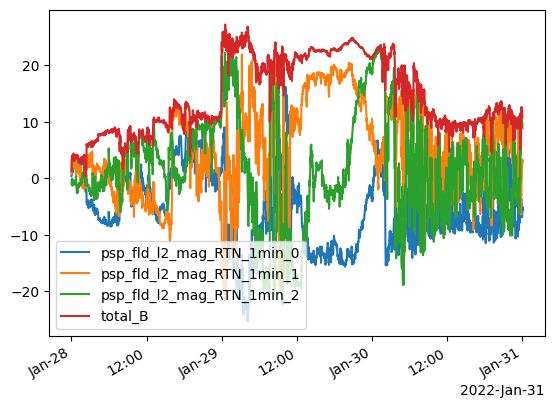

In [8]:
clean_psp = psp_fields_mag._data[psp_fields_mag._data["psp_fld_l2_quality_flags"].isnull()]
psp_fields_mag_clean = TimeSeries(clean_psp, psp_fields_mag.meta, psp_fields_mag.units)

total_B = np.sqrt(psp_fields_mag_clean.quantity('psp_fld_l2_mag_RTN_1min_0')**2 +
                  psp_fields_mag_clean.quantity('psp_fld_l2_mag_RTN_1min_1')**2 +
                  psp_fields_mag_clean.quantity('psp_fld_l2_mag_RTN_1min_2')**2)

psp_fields_mag_clean = psp_fields_mag_clean.add_column("total_B", total_B)

psp_fields_mag_clean.plot(columns=["psp_fld_l2_mag_RTN_1min_0", "psp_fld_l2_mag_RTN_1min_1", "psp_fld_l2_mag_RTN_1min_2", "total_B"])

Solar wind speed

In [9]:
bulk_speed_magnitude = np.sqrt(psp_spc._data["vp_moment_RTN_0"]**2 + 
                               psp_spc._data["vp_moment_RTN_1"]**2 + 
                               psp_spc._data["vp_moment_RTN_2"]**2)
psp_spc = psp_spc.add_column("bulk_vp_magnitude", bulk_speed_magnitude)

Proton Temperature

In [13]:
# Convert Proton thermal speed to Proton temperature (eV)
p_mass = c.m_p.value
kb = c.k_B.value
kb_eV = kb * 1/(c.e.value)

p_temp = (psp_spc._data['wp_moment']*1000)**2*p_mass/(2*kb) * kb_eV

psp_spc = psp_spc.add_column("proton_temperature", p_temp)

Plot

In [ ]:
# Plot time series
fig, ax  = plt.subplots(5, sharex=True, figsize=(10, 10))

# total B field
psp_fields_mag_clean._data["total_B"].plot(ax=ax[0], color='k')
ax[0].set_ylabel("|B| (nT)")

# B field x, y, z
psp_fields_mag_clean._data[["psp_fld_l2_mag_RTN_1min_0", 
                            "psp_fld_l2_mag_RTN_1min_1", 
                            "psp_fld_l2_mag_RTN_1min_2"]].plot(ax=ax[1])

ax[1].legend(labels=["$B_r$", "$B_t$", "$B_n$"], loc="upper left")
ax[1].set_ylabel("B$_{RTN}$ (nT)")
ax[1].set_ylim(-25, 25)

# proton density
psp_spc._data["np_moment"].plot(ax=ax[2], ls='', marker='.',ms=1)
ax[2].set_ylim(0, 90)
ax[2].set_ylabel("N$_p$ ({:s})".format(psp_spc.quantity("np_moment").unit))

# proton temperature
psp_spc._data["proton_temperature"].plot(ax=ax[3], ls='', marker='.', ms=1)
ax[3].set_ylim(0, 60)
ax[3].set_ylabel("$T_p$ (eV)")

# proton bulk speed
psp_spc._data["bulk_vp_magnitude"].plot(ax=ax[4], marker='.', ls='', ms=1)
ax[4].set_ylabel("V$_{SW}$ (km/s)")
plt.axhline(400, ls="dashed")
    
ax[0].set_xlim(psp_spc.time[0].datetime, psp_spc.time[-1].datetime)
ax[4].set_xlabel("Time")
plt.tight_layout()
plt.subplots_adjust(hspace=0.02)

## Solar Orbiter

In [14]:
# Search and download SWA data
res_solo_swa = Fido.search(a.Time(tstart, tend), a.cdaweb.Dataset.solo_l2_swa_pas_grnd_mom)
files_solo_swa = Fido.fetch(res_solo_swa, path=solo_data_path)

# Search and download solo mag data
res_solo_mag = Fido.search(a.Time(tstart, tend), a.cdaweb.Dataset('SOLO_L2_MAG-RTN-NORMAL-1-MINUTE'))
files_solo_mag = Fido.fetch(res_solo_mag, path=solo_data_path)

Files Downloaded: 100%|██████████| 3/3 [00:00<00:00,  8.51file/s]


In [ ]:
# Create time series for both swa and mag datasets
solo_swa_pas = TimeSeries(files_solo_swa, concatenate=True)
solo_mag = TimeSeries(files_solo_mag, concatenate=True)

In [18]:
total_B_solo = np.sqrt(solo_mag.quantity('B_RTN_0')**2 +
                solo_mag.quantity('B_RTN_1')**2 +
                solo_mag.quantity('B_RTN_2')**2)

solo_mag = solo_mag.add_column("total_B", total_B_solo)

total_v = np.sqrt(solo_swa_pas.quantity('V_RTN_0')**2 +
                solo_swa_pas.quantity('V_RTN_1')**2 +
                solo_swa_pas.quantity('V_RTN_2')**2)

solo_swa_pas = solo_swa_pas.add_column("bulk_sw", total_v)

Plot

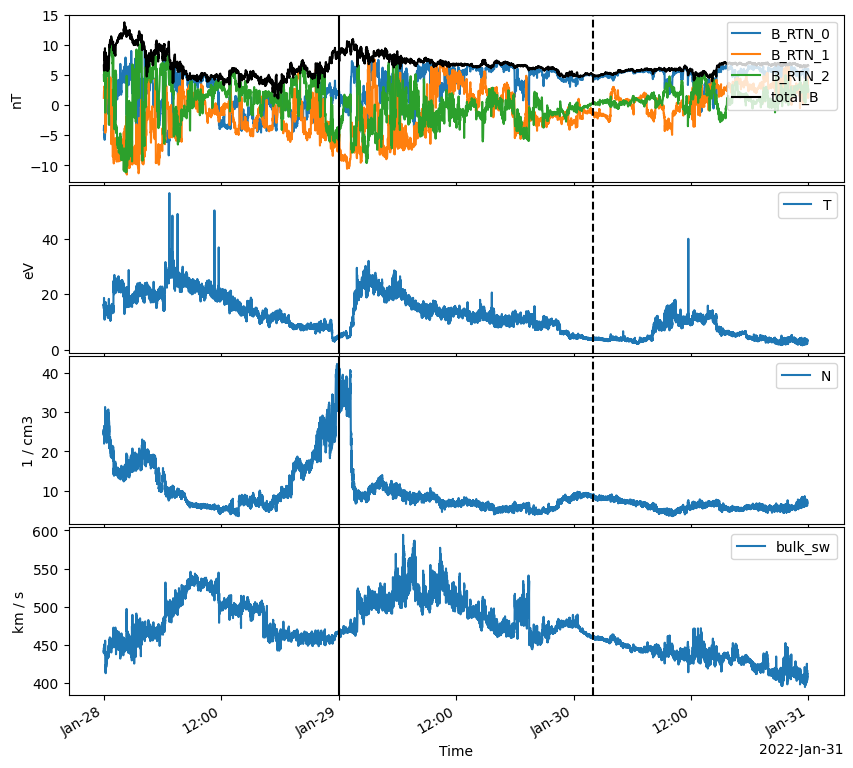

In [19]:
fig, ax = plt.subplots(4, figsize=(10, 10), sharex=True)

solo_mag.plot(columns=['B_RTN_0', 'B_RTN_1', 'B_RTN_2'], axes=ax[0])
solo_mag.plot(columns=['total_B'], axes=ax[0], color='k')
solo_swa_pas.plot(columns=['T'], axes=ax[1])
solo_swa_pas.plot(columns=['N'], axes=ax[2])
solo_swa_pas.plot(columns=['bulk_sw'], axes=ax[3])
ax[3].set_xlabel("Time")


for aa in ax:
    aa.legend(loc="upper right")
    aa.axvline("2022-01-29 00:00", color='k')
    aa.axvline("2022-01-30 02:00", color='k', ls="dashed")
    
plt.subplots_adjust(hspace=0.02)

# Step 2: Time Series Comparison between Parker Solar Probe and Solar Orbiter

Comparison of total magnetic field magnitude as well as $B_{RTN}$ components detected by PSP and SoLO over the same time period defined at the beginning of this notebook.

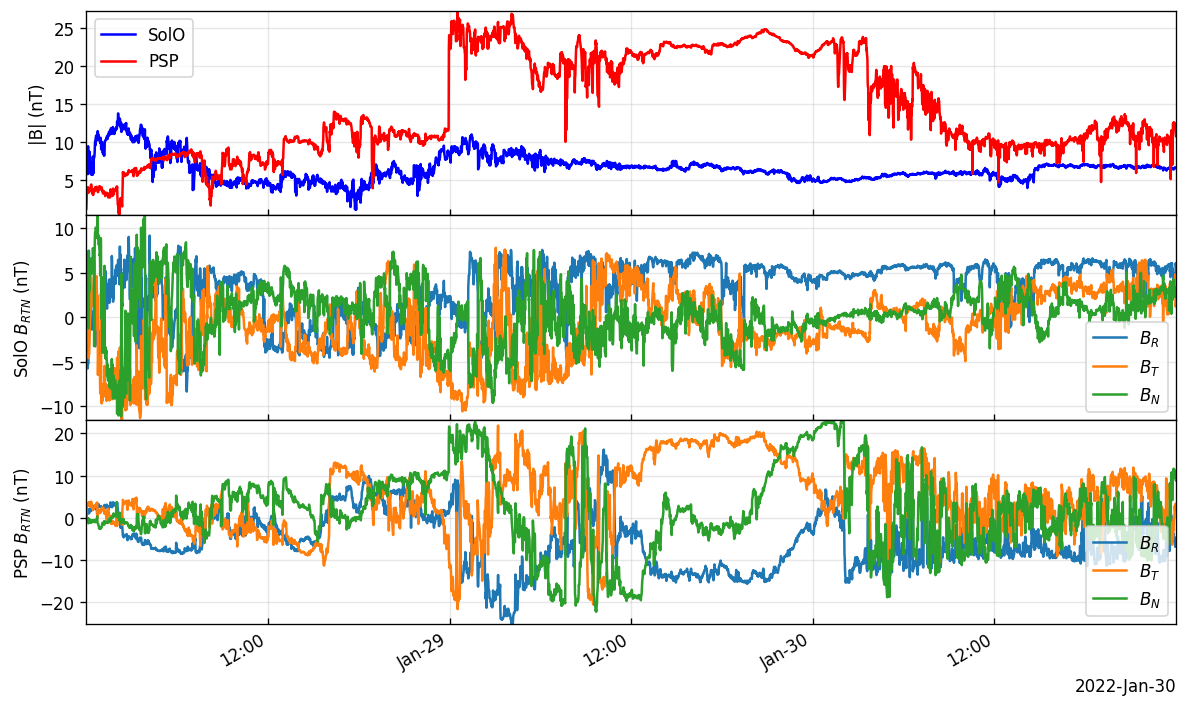

In [ ]:
fig, ax = plt.subplots(3, figsize=(10, 6), sharex=True, dpi=120)

# Total B magnitude comparison
solo_mag.plot(columns=['total_B'], axes=ax[0], color='b')
psp_fields_mag_clean.plot(columns=['total_B'], axes=ax[0], color='r')
ax[0].set_ylabel("|B| (nT)")
ax[0].legend(labels=["SolO", "PSP"], loc="upper left")

# SolO B_RTN
solo_mag.plot(columns=['B_RTN_0', 'B_RTN_1', 'B_RTN_2'], axes=ax[1])
ax[1].set_ylabel("SolO $B_{RTN}$ (nT)")
ax[1].legend(labels=["$B_R$", "$B_T$", "$B_N$"], loc="lower right")

# PSP B_RTN
psp_fields_mag_clean._data[["psp_fld_l2_mag_RTN_1min_0", 
                            "psp_fld_l2_mag_RTN_1min_1", 
                            "psp_fld_l2_mag_RTN_1min_2"]].plot(ax=ax[2])

ax[2].set_ylabel("PSP $B_{RTN}$ (nT)")
ax[2].legend(labels=["$B_R$", "$B_T$", "$B_N$"], loc="lower right")

# Remove margins, set inwards ticks and grid
for aa in ax:
    aa.tick_params(axis='x', direction='in')
    aa.margins(x=0, y=0)
    aa.grid('.', alpha=0.3)

plt.tight_layout()
plt.subplots_adjust(hspace=0)

Comparison of 3 wind parameters: Proton Temperature, Density and Speed as detected by the SWA and SWEAP instruments of SolO and PSP respectively during the same time period as defined in the beginning of this notebook.

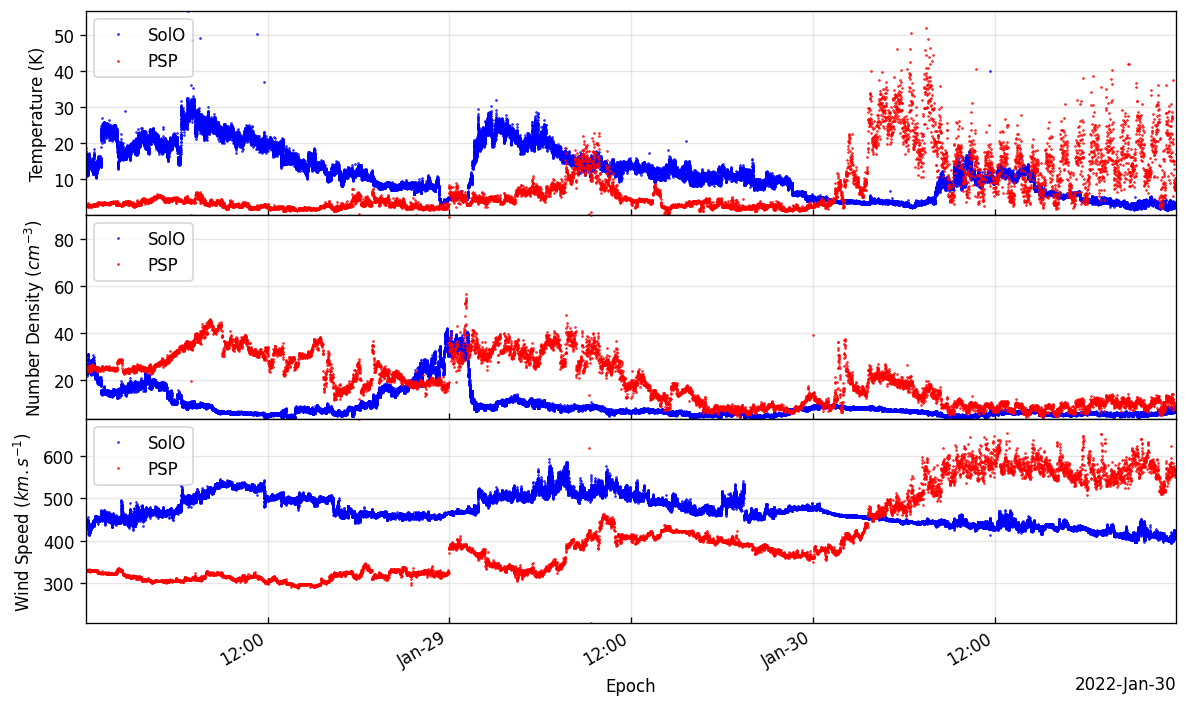

In [ ]:
fig, ax = plt.subplots(3, figsize=(10, 6), sharex=True, dpi=120)

# Proton Temperature Comparison
solo_swa_pas.plot(columns=['T'], axes=ax[0], ls='', marker='.', ms=1, c='b')
psp_spc.plot(columns=['proton_temperature'], axes=ax[0], ls='', marker='.', ms=1, c='r')
ax[0].set_ylabel("Temperature (K)")

# Proton Density Comparison
solo_swa_pas.plot(columns=['N'], axes=ax[1], ls='', marker='.', ms=1, c='b')
psp_spc.plot(columns=["np_moment"], axes=ax[1], ls='', marker='.', ms=1, c='r')
ax[1].set_ylabel("Number Density ($cm^{-3}$)")

# Wind Speed Comparison
solo_swa_pas.plot(columns=['bulk_sw'], axes=ax[2], marker='.', ls='', ms=1, c='b')
psp_spc.plot(columns=["bulk_vp_magnitude"], axes=ax[2], marker='.', ls='', ms=1, c='r')
ax[2].set_ylabel("Wind Speed ($km.s^{-1}$)")

# Remove margins, set inwards ticks, set ticks and legends
for aa in ax:
    aa.tick_params(axis='x', direction='in')
    aa.margins(x=0, y=0)
    aa.grid('.', alpha=0.3)
    aa.legend(labels=["SolO", "PSP"], loc="upper left")

plt.tight_layout()
plt.subplots_adjust(hspace=0)